In [ ]:
from tensorflow import keras
print('keras: ', keras.__version__)

keras:  2.12.0


In [ ]:
# For Google Colaboratory
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/gdrive')
    path_to_file = '/content/gdrive/My Drive/Computer_Science_Files/NUS_courses/Deep_Learning/Lab' # Please adjust the path accordingly
    os.chdir(path_to_file)
    !pwd

Mounted at /content/gdrive
/content/gdrive/My Drive/Computer_Science_Files/NUS_courses/Deep_Learning/Lab


In [ ]:
#only need to run it once to unzip the image file
# uncomment and run once
# !unzip -qq cats_and_dogs_small.zip

replace cats_and_dogs_small/test/cats/cat.1501.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
error:  cannot create cats_and_dogs_small/test/cats/cat.1501.jpg
        No such file or directory


## Objectives
After completing this practical exercise, students should be able to:
1. [Training a convnet from scratch on a small dataset](#demo)
2. [Exercise- tuning several model parameters](#exc)

## 1. Training a convnet from scratch on a small dataset <a id='demo' />

In this practical example, we will focus on classifying images as "dogs" or "cats". We will start by naively training a small convnet on our training samples, without any regularization, to set a baseline for what can be achieved. This will get us to a classification accuracy of around 80%. At that point, our main issue will be overfitting. Then we will introduce *data augmentation*, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve our network to reach an accuracy of around 90%.

### 1.1 Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras. It was made available by Kaggle.com as part of a computer vision competition in late 2013, back when convnets weren't quite mainstream. The original dataset is available at:
`https://www.kaggle.com/c/dogs-vs-cats/data`.

This original dataset contains 25,000 images of dogs and cats (12,500 from each class) and is 543MB large (compressed). In this Practical we will use a subset ("cats_and_dogs_small.zip") of the original dataset. It contains 4000 pictures of cats and dogs (2000 cats, 2000 dogs) and we will use 2000 pictures (1000 cats, 1000 dogs) for training, 1000 (500 cats, 500 dogs) for validation, and finally 1000 (500 cats, 500 dogs) for testing. You can download this small dataset ("cats_and_dogs_small.zip", around 90MB) from website and then unzip it. After that please assign directory you save the images to base_dir as shown below.

In [ ]:
import os
base_dir = './cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

### 1.2 Building our network

Our convnet will be a stack of alternated `Conv2D` (with `relu` activation) and `MaxPooling2D` layers. We start from inputs of size 50x50 (a somewhat arbitrary choice), we end up with output of size 1x1 right before the `Flatten` layer.

Note that the depth of the output is progressively increasing in the network (from 32 to 128), while the size of the output is
decreasing (from 48x48 to 1x1). This is a pattern that you will see in almost all convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a `sigmoid` activation. This unit will output the classification probability of one class or the other.

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import models

# We set image size as 50*50
img_size = 50

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the Output Shape change with every successive layer:

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 4, 4, 128)       

For our compilation step, we'll go with the `RMSprop` optimizer as usual. Since we ended our network with a single sigmoid unit, we will use binary crossentropy as our loss.

In [ ]:
from tensorflow.keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

### 1.3 Data preprocessing

As you already know by now, data should be formatted into appropriately pre-processed floating point tensors before being fed into our
network. Currently, our data sits on a drive as JPEG files, so the steps for getting it into our network are roughly:

* Read the picture files.
* Decode the JPEG content to RBG grids of pixels.
* Convert these into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the [0, 1] interval

It may seem a bit daunting, but thankfully Keras has utilities to take care of these steps automatically. Keras has a module with image
processing helper tools, located at `keras.preprocessing.image`. It contains the class `ImageDataGenerator` which allows to
quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. This is what we will use here.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_size, img_size),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 50x50 RGB images (shape `(20, 50, 50, 3)`) and binary labels (shape `(20,)`). 20 is the number of samples in each batch (the batch size). Note that the generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder, so we need to `break` the iteration loop at some point.

In [ ]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 50, 50, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit_generator` method, the equivalent of `fit` for data generators like ours. It expects as first argument a Python generator that will yield batches of inputs and targets indefinitely.
Because the data is being generated endlessly, the generator needs to know how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-sample large, so it will take 100 batches (=20*100 samples) until we see our target of 2000 samples.

When using `fit_generator`, one may pass a `validation_data` argument, much like with the `fit` method. Importantly, this argument is mostly a data generator.  After you pass a generator to `validation_data`, then
this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation.

In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 25s 134ms/step - loss: 0.6981 - acc: 0.5155 - val_loss: 0.6951 - val_acc: 0.5000
Epoch 2/30
100/100 [==============================] - 14s 145ms/step - loss: 0.6914 - acc: 0.5280 - val_loss: 0.6852 - val_acc: 0.5330
Epoch 3/30
100/100 [==============================] - 20s 198ms/step - loss: 0.6764 - acc: 0.5650 - val_loss: 0.6602 - val_acc: 0.6310
Epoch 4/30
100/100 [==============================] - 17s 167ms/step - loss: 0.6577 - acc: 0.6125 - val_loss: 0.6373 - val_acc: 0.6400
Epoch 5/30
100/100 [==============================] - 16s 160ms/step - loss: 0.6251 - acc: 0.6520 - val_loss: 0.6512 - val_acc: 0.6040
Epoch 6/30
100/100 [==============================] - 15s 149ms/step - loss: 0.5861 - acc: 0.6915 - val_loss: 0.6112 - val_acc: 0.6680
Epoch 7/30
100/100 [==============================] - 14s 139ms/step - loss: 0.5365 - acc: 0.7335 - val_loss: 0.6152 - val_acc: 0.6720
Epoch 8/30
100/100 [==============================] - 1

It is good practice to always save your models after training:

In [ ]:
model.save('cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

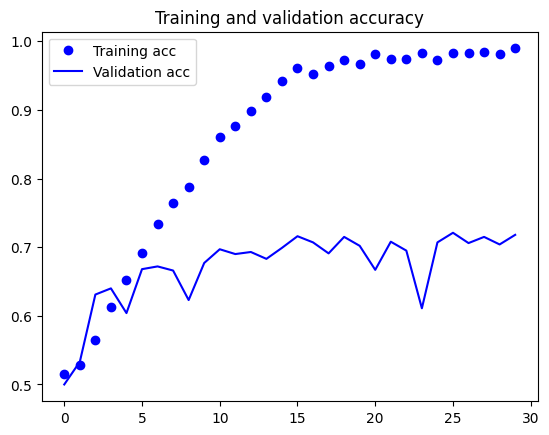

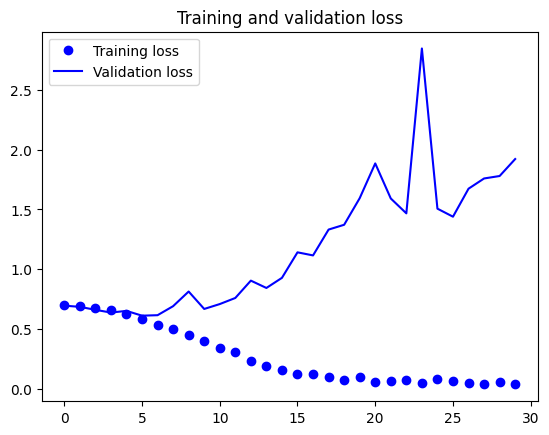

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

We can easily see overfitting through these plots. Our training accuracy increases linearly over time, until it reaches nearly 90%, while our validation accuracy stalls at around 70%. Our validation loss reaches its minimum after only a few epochs then stalls, while the training loss keeps decreasing linearly until it reaches nearly 0.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L2 regularization). We are now going to introduce a new one, specific to computer vision, and used almost universally when processing images with deep learning models: *data augmentation*.

### 1.4 Using data augmentation

Overfitting is caused by having too few samples to learn from, rendering us unable to train a model able to generalize to new data.
Given infinite data, our model would be exposed to every possible aspect of the data distribution at hand: we would never overfit. Data
augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number
of random transformations that yield believable-looking images. The goal is that at training time, our model would never see the exact same
picture twice. This helps the model get exposed to more aspects of the data and generalize better.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by our `ImageDataGenerator`
instance. Let's get started with an example:

In [ ]:
datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (for more, see the Keras documentation). Let's quickly go over what we just wrote:

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly translate pictures
vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally -- relevant when there are no assumptions of horizontal
asymmetry (e.g. real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look at our augmented images:

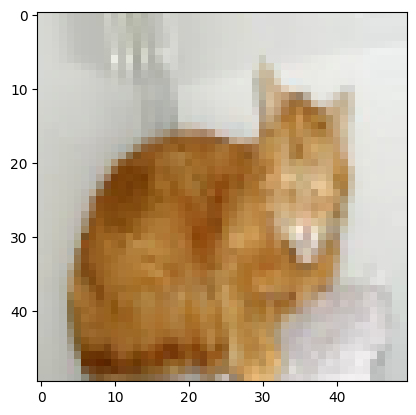

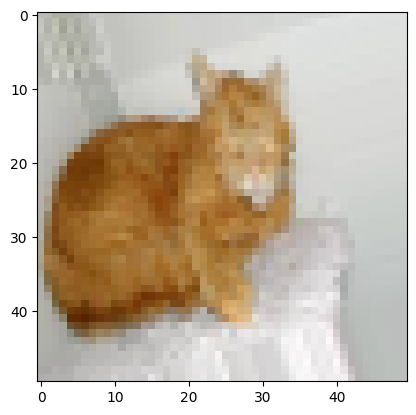

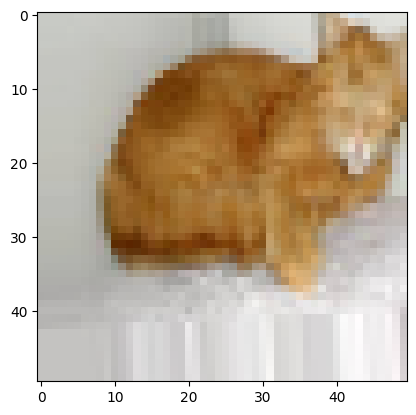

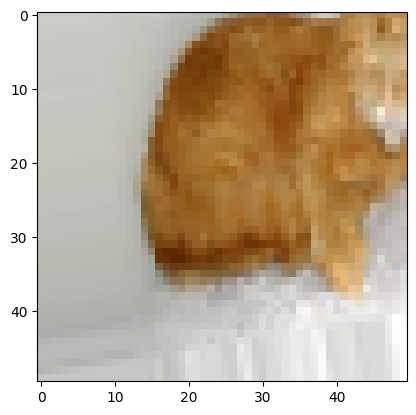

In [ ]:
# This is module with image preprocessing utilities
import os
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing import image
train_cats_dir = os.path.join(base_dir, 'train/cats')

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(img_size, img_size))

# Convert it to a Numpy array with shape (50, 50, 3)
x = image.img_to_array(img)

# Reshape it to (1, 50, 50, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break


plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs
that it sees are still heavily intercorrelated, since they come from a small number of original images -- we cannot produce new information,
we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight
overfitting, we will also add a Dropout layer to our model, right before the densely-connected classifier:

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 24, 24, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 11, 11, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 4, 4, 128)       

Let's train our network using data augmentation and dropout:

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 50x50
        target_size=(img_size, img_size),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=20,
        class_mode='binary')



Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
history = model.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/100
100/100 [==============================] - 18s 150ms/step - loss: 0.7016 - acc: 0.5095 - val_loss: 0.6947 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 14s 139ms/step - loss: 0.6935 - acc: 0.5210 - val_loss: 0.6853 - val_acc: 0.5940
Epoch 3/100
100/100 [==============================] - 14s 140ms/step - loss: 0.6865 - acc: 0.5530 - val_loss: 0.6688 - val_acc: 0.6150
Epoch 4/100
100/100 [==============================] - 14s 141ms/step - loss: 0.6806 - acc: 0.5800 - val_loss: 0.6438 - val_acc: 0.6270
Epoch 5/100
100/100 [==============================] - 15s 146ms/step - loss: 0.6697 - acc: 0.5930 - val_loss: 0.6445 - val_acc: 0.6400
Epoch 6/100
100/100 [==============================] - 14s 141ms/step - loss: 0.6618 - acc: 0.5995 - val_loss: 0.6232 - val_acc: 0.6620
Epoch 7/100
100/100 [==============================] - 15s 150ms/step - loss: 0.6534 - acc: 0.6165 - val_loss: 0.6387 - val_acc: 0.6260
Epoch 8/100
100/100 [===========================

In [ ]:
model.save('cats_and_dogs_small_2.h5')

Let's plot our results again:

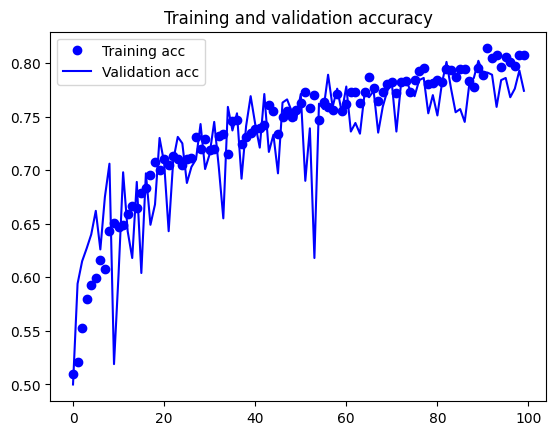

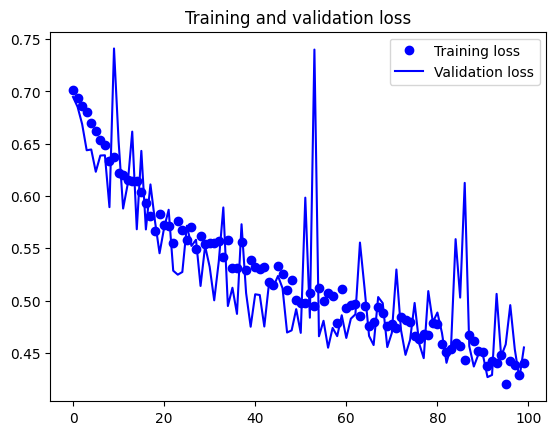

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Thanks to data augmentation and dropout, we are no longer overfitting: the training curves are rather closely tracking the validation curves. We are now able to reach an accuracy of 75%, a 15% relative improvement over the non-regularized model.

## 2. Exercise - tuning model parameters <a id='exc' />

Please try to further improve model performance by tuning below hyperparameters:
* `batch_size` and `steps_per_epoch` (Do note: `steps_per_epoch` = total number of train samples // `batch_size`)
* Optimizer and Optimizer Learning Rate
* Any other suitable hyperparameters


Provide your codes & comments in the below boxes.

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 50x50
        target_size=(img_size, img_size),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_size, img_size),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
# try to modify parameters to increase accuracy while lowering accuracy loss.
from tensorflow.keras import layers
from tensorflow.keras import models

# We set image size as 50*50
img_size = 50

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(img_size, img_size, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=0.001),
              metrics=['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 22, 22, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 11, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 9, 128)         73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 128)       

In [1]:
history = model.fit(
      train_generator,
      steps_per_epoch=50, # (total no. of train samples / batch size)
      epochs=150,
      validation_data=validation_generator,
      validation_steps=50)

NameError: name 'model' is not defined

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
# upward trend as the epochs go on, though there is eratic validation accuracy and loss around 20 epochs